In [61]:
# --- 1. Imports ---
from ultralytics import YOLO
from paddleocr import PaddleOCR
import re
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import easyocr
import numpy as np

# --- 2. Cargar modelo YOLO ---
ids_model = YOLO("/home/gnz/GitHub/yolo11_container/YOLO_IDs/ID_YOLO_container/weights/best.pt")

char_model = YOLO("/home/gnz/GitHub/yolo11_container/YOLO_Characters/Character_YOLO_container/weights/best.pt")

# --- 3. Inicializar EasyOCR ---
easy_ocr_model = easyocr.Reader(['en','es'])  # podés agregar ['en', 'es'] si querés español
# PaddleOCR inicializado (puedes ajustar lang si necesitas chino, inglés, etc.)
paddle_ocr_model = PaddleOCR(use_textline_orientation=True, lang="en")


[2025-09-11 11:36:57,607] [ WARNING] easyocr.py:80 - Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/gnz/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/gnz/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/gnz/.paddlex/official_models/UVDoc`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/gnz/.paddlex/official_models/UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist

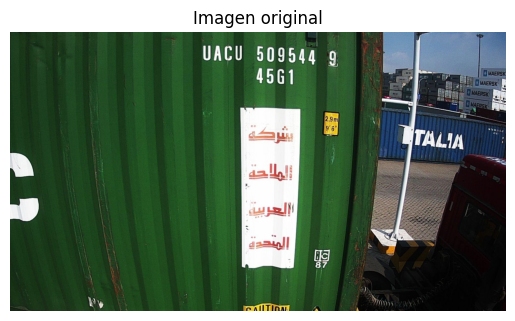

In [ ]:
# --- 4. Cargar imagen de prueba ---
image_path_cn11 = "/home/gnz/GitHub/yolo11_container/images/1-124629001-OCR-RF-D01_jpg.rf.7461114c8ca66fe0915742ff2444bc2e.jpg"
image = cv2.imread(image_path_cn11)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # convertir a RGB
plt.imshow(image)
plt.title("Imagen original")
plt.axis("off")
plt.show()


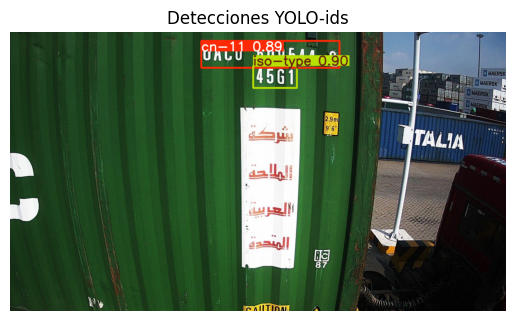

In [96]:
# --- 5. Inferencia con YOLO-ids ---
results_ids = ids_model.predict(image, conf=0.25, verbose=False)
annotated = results_ids[0].plot()  # imagen con bounding boxes dibujados

plt.imshow(annotated)
plt.title("Detecciones YOLO-ids")
plt.axis("off")
plt.show()

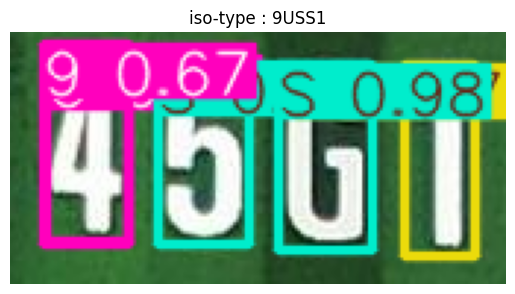

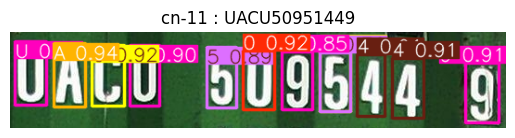

{'iso-type': '9USS1', 'cn-11': 'UACU50951449'}


In [97]:
detecciones = {}  # aquí guardaremos "clase del primer modelo" : "string del segundo modelo"

# --- Loop sobre detecciones del primer modelo ---
for i, box in enumerate(results_ids[0].boxes):
    # Coordenadas del bounding box del primer modelo
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    crop = image[y1:y2, x1:x2]

    # Obtener clase del primer modelo
    cls_id = int(box.cls[0].item())
    cls_name = results_ids[0].names[cls_id]  # p.ej. "iso-type"

    # Inferencia con YOLO-characters en el crop
    results_char = char_model.predict(crop, conf=0.25, verbose=False)

    # Extraer nombres de las clases del segundo modelo (caracteres detectados)
    chars = []
    for char_box in results_char[0].boxes:
        char_id = int(char_box.cls[0].item())
        char_name = results_char[0].names[char_id]
        chars.append(char_name)

    # Concatenar caracteres en un string (ordenar por X si quieres respetar el orden visual)
    # Ordenar por coordenada X del bounding box
    boxes_with_chars = sorted(
        zip(results_char[0].boxes.xyxy.tolist(), chars),
        key=lambda b: b[0][0]  # ordenar por x1
    )
    string_detectado = "".join([c for _, c in boxes_with_chars])

    # Guardar en el diccionario
    detecciones[cls_name] = string_detectado

    # Mostrar el crop anotado
    annotated_char = results_char[0].plot()
    plt.imshow(annotated_char)
    plt.title(f"{cls_name} : {string_detectado}")
    plt.axis("off")
    plt.show()

print(detecciones)
